# **Imports**

In [10]:
# Common
import os
import cv2 as cv
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np 

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
# from tensorflow.keras.utils import img_to_array, load_img

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import load_img, img_to_array

<function tensorflow.python.keras.preprocessing.image.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest')>

In [6]:




# viz


# Model
import keras 
import tensorflow as tf
# from keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
# from keras import Sequential 
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.metrics import MeanIoU

# data 

# from keras.preprocessing.image import load_img, img_to_array
# from keras_preprocessing.image import load_img, img_to_array
# from tensorflow.keras.utils import img_to_array, load_img

2023-01-01 13:24:16.823702: E tensorflow/core/lib/monitoring/collection_registry.cc:77] Cannot register 2 metrics with the same name: /tensorflow/api/keras/optimizers


AlreadyExistsError: Another metric with the same name already exists.

# **Data**

In [7]:
images = []
mask = []

# image_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/'
# mask_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/'

image_path = './waterBodiesDataset/Images/'
mask_path = './waterBodiesDataset/Masks/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
    print('Image and Mask are corretly Placed!!')

Image and Mask are corretly Placed!!


## I ADDED THIS TO MAKE TRAINING FASTER; REMOVE FOR FINAL

In [10]:
image_names = image_names[:100]
mask_names = mask_names[:100]

NameError: name 'image_names' is not defined

In [11]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    img = img_to_array(load_img(path)).astype('float')/255.
    img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
    images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
    path = mask_path + mask_names[id]
    mask = img_to_array(load_img(path)).astype('float')/255.
    mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
    masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 100/100 [00:00<00:00, 134.09it/s]


In [12]:
def show_image(image, title=None, cmap=None):
    plt.imshow(image, cmap=cmap)
    if title is not None: plt.title(title)
    plt.axis('off')

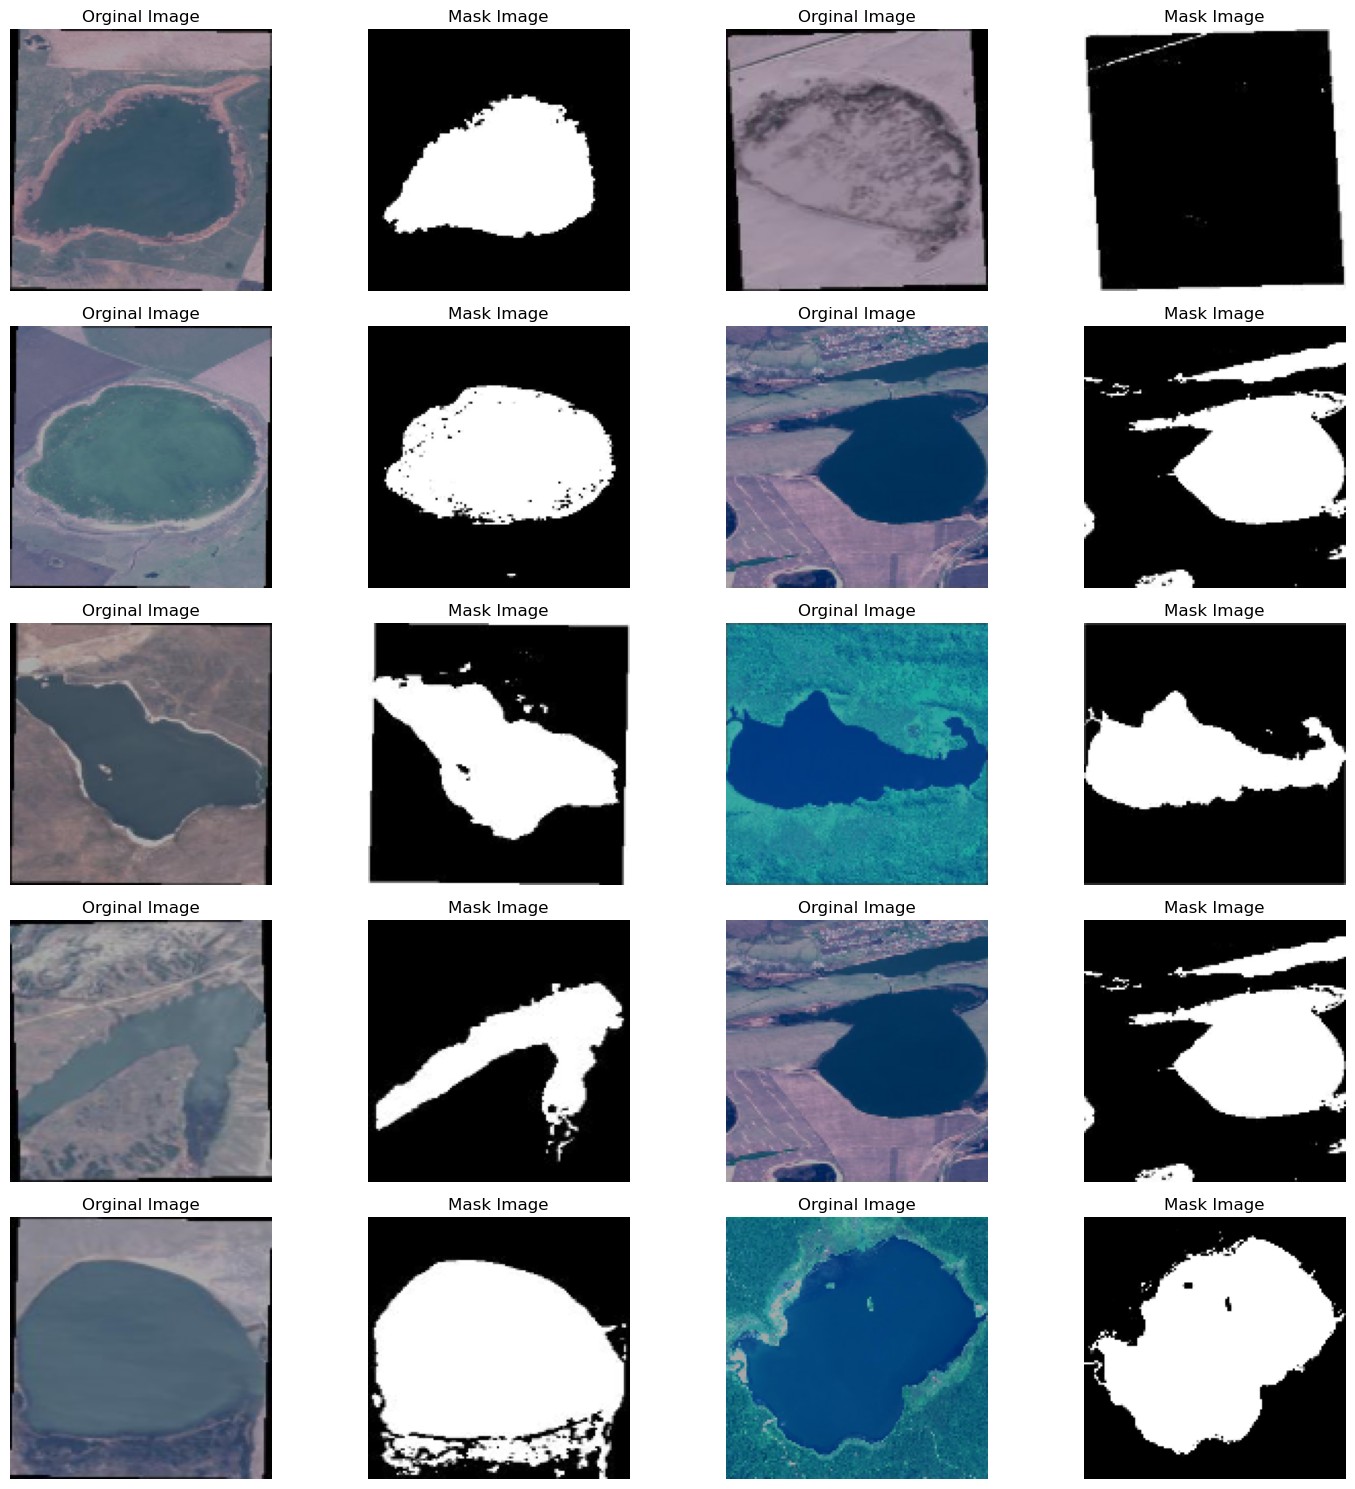

In [13]:
plt.figure(figsize=(15,15))
for i in range(1,21):
    plt.subplot(5,4,i)
    if i%2!=0:
        id = np.random.randint(len(images))
        show_image(images[id], title="Orginal Image")
    elif i%2==0:
        show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')
plt.tight_layout()
plt.show()

# **U-Net**

In [14]:
X, y = images[:int(len(images)*0.9)], masks[:int(len(images)*0.9)]
test_X, test_y = images[int(len(images)*0.9):], masks[int(len(images)*0.9):]

In [15]:
# Contraction 
class EncoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate, pooling=True):
        super(EncoderBlock,self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.conv1 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.conv2 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        if self.pooling: 
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

# Expansion
class DecoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate):
        super(DecoderBlock,self).__init__()
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)
    def call(self, inputs):
        X, short_X = inputs
        ct = self.up(X)
        c_ = concatenate([ct, short_X])
        x = self.net(c_)
        return x
 

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate
        }

# Callback 
class ShowProgress(keras.callbacks.Callback):
    def __init__(self, SIZE):
        self.SIZE = SIZE
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = self.model.predict(real_img)[0]
        mask = masks[id]

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        show_image(real_img[0], title="Orginal Image")

        plt.subplot(1,3,2)
        show_image(pred_mask, title="Predicted Mask", cmap='gray')

        plt.subplot(1,3,3)
        show_image(mask, title="Orginal Mask", cmap='gray')


        plt.tight_layout()
        plt.show()

2022-12-31 11:51:37.862019: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-31 11:51:37.863262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (devDogra1): /proc/driver/nvidia/version does not exist
2022-12-31 11:51:37.869964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


2022-12-31 11:51:40.869988: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.
2022-12-31 11:51:41.216385: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.


1/3 [=========>....................] - ETA: 9s - loss: 0.8159 - accuracy: 0.2804 - IoU: 0.3598

2022-12-31 11:51:43.310059: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.
2022-12-31 11:51:43.603381: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.


1/1 [==============================] - 0s 154ms/steps: 1.4483 - accuracy: 0.2870 - IoU: 0.35


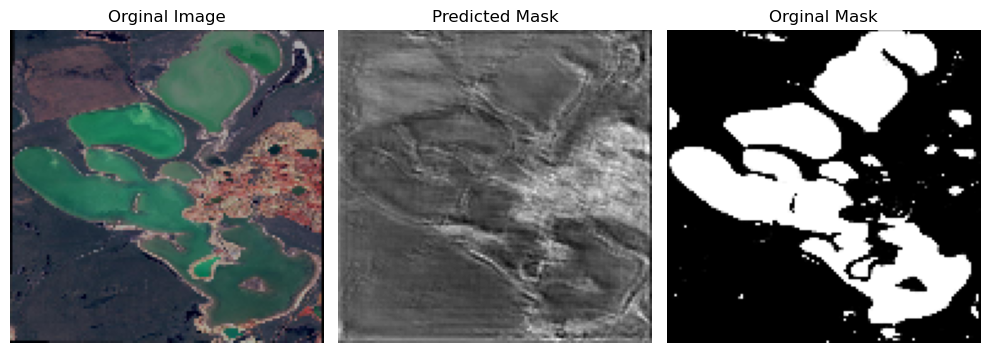

3/3 [==============================] - 10s 2s/step - loss: 1.4483 - accuracy: 0.2870 - IoU: 0.3568 - val_loss: 0.7028 - val_accuracy: 0.2703 - val_IoU: 0.3912
Epoch 2/20


2022-12-31 11:51:48.326398: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.


1/1 [==============================] - 0s 35ms/stepss: 0.6966 - accuracy: 0.3590 - IoU: 0.35


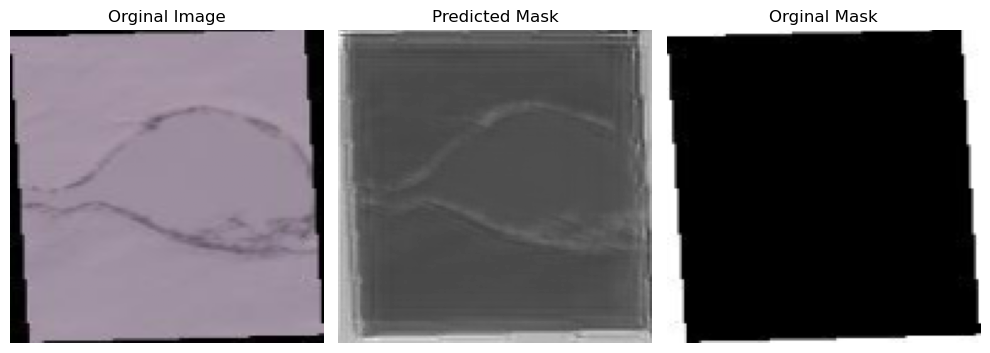

3/3 [==============================] - 7s 2s/step - loss: 0.6966 - accuracy: 0.3590 - IoU: 0.3568 - val_loss: 0.6606 - val_accuracy: 0.5243 - val_IoU: 0.3912
Epoch 3/20
1/1 [==============================] - 0s 25ms/stepss: 0.6593 - accuracy: 0.5056 - IoU: 0.35


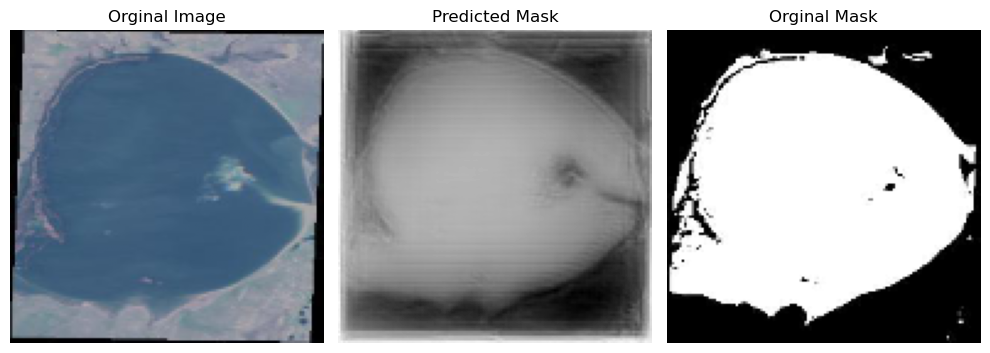

3/3 [==============================] - 7s 2s/step - loss: 0.6593 - accuracy: 0.5056 - IoU: 0.3568 - val_loss: 0.6282 - val_accuracy: 0.5275 - val_IoU: 0.3912
Epoch 4/20
1/1 [==============================] - 0s 20ms/stepss: 0.6238 - accuracy: 0.5088 - IoU: 0.35


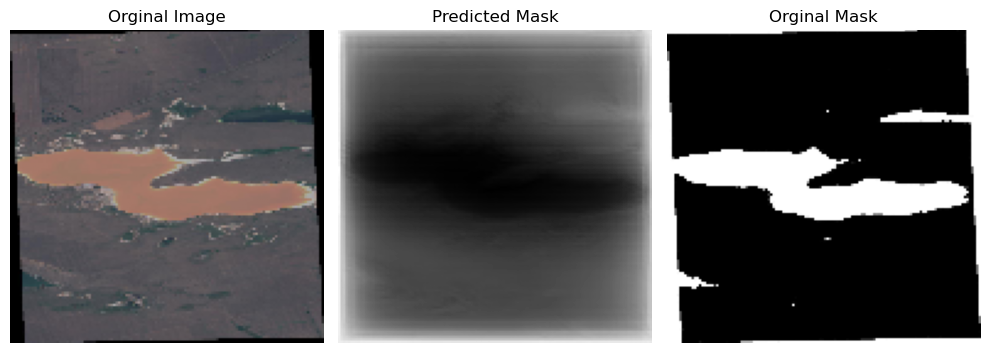

3/3 [==============================] - 7s 2s/step - loss: 0.6238 - accuracy: 0.5088 - IoU: 0.3568 - val_loss: 0.6540 - val_accuracy: 0.5280 - val_IoU: 0.3912
Epoch 5/20
1/1 [==============================] - 0s 22ms/stepss: 0.6018 - accuracy: 0.5103 - IoU: 0.35


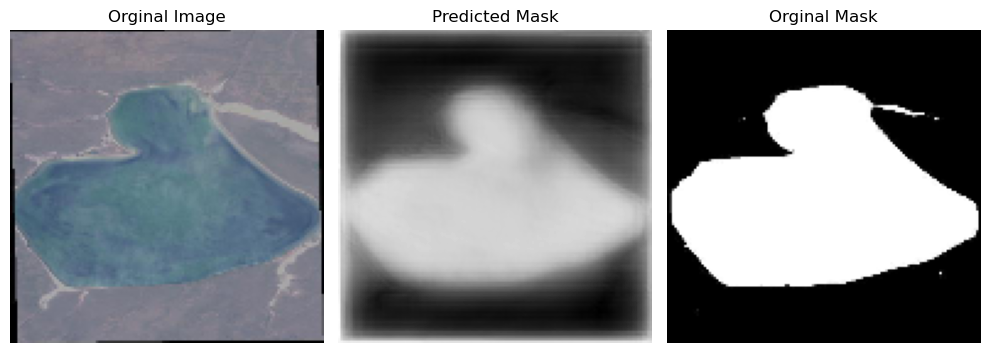

3/3 [==============================] - 7s 2s/step - loss: 0.6018 - accuracy: 0.5103 - IoU: 0.3568 - val_loss: 0.6048 - val_accuracy: 0.5280 - val_IoU: 0.3912
Epoch 6/20
1/1 [==============================] - 0s 24ms/stepss: 0.5910 - accuracy: 0.5110 - IoU: 0.35


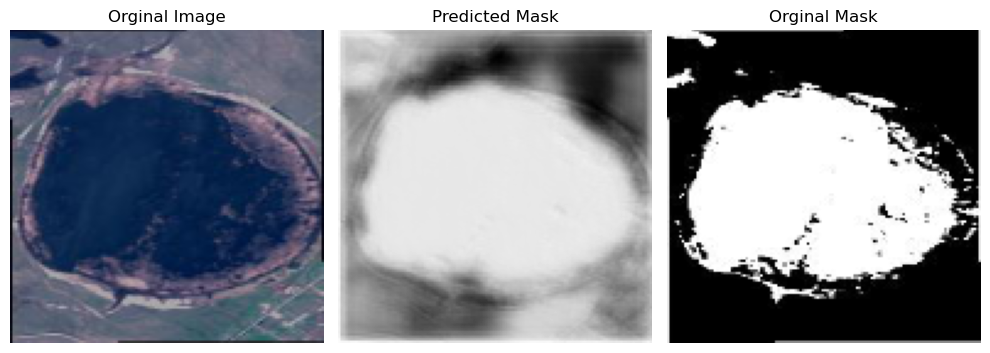

3/3 [==============================] - 7s 2s/step - loss: 0.5910 - accuracy: 0.5110 - IoU: 0.3568 - val_loss: 0.6187 - val_accuracy: 0.5281 - val_IoU: 0.3912
Epoch 7/20
1/1 [==============================] - 0s 32ms/stepss: 0.5830 - accuracy: 0.5110 - IoU: 0.35


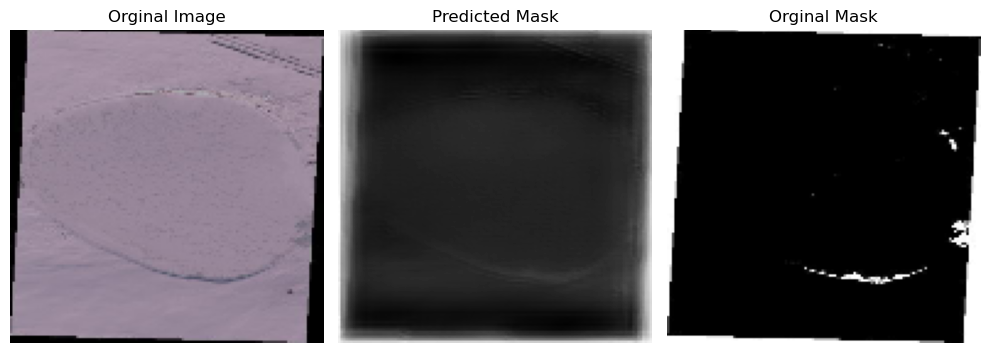

3/3 [==============================] - 7s 2s/step - loss: 0.5830 - accuracy: 0.5110 - IoU: 0.3568 - val_loss: 0.6269 - val_accuracy: 0.5282 - val_IoU: 0.3912
Epoch 8/20
1/1 [==============================] - 0s 23ms/stepss: 0.5760 - accuracy: 0.5111 - IoU: 0.35


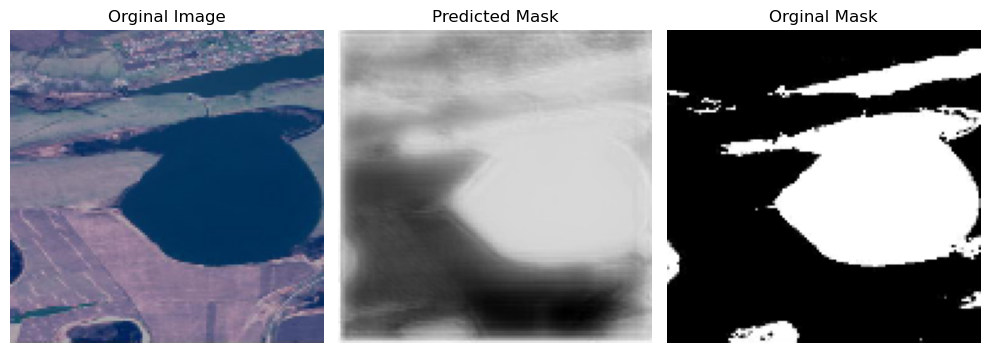

3/3 [==============================] - 7s 2s/step - loss: 0.5760 - accuracy: 0.5111 - IoU: 0.3568 - val_loss: 0.6443 - val_accuracy: 0.5276 - val_IoU: 0.3912


In [16]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction 
p1,c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4) 

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1)([d3,c1])

# Outputs 
outputs = Conv2D(1,1,activation='sigmoid')(d4)

# Model
unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

# Compiling
unet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2, name="IoU")]
)
# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),# The Model will train quickly use it if you want it, For model Comparision I am not using it
    ModelCheckpoint("UNet.h5", save_best_only=True),
    ShowProgress( SIZE=SIZE)
]

# Training
unet_history = unet.fit(
    X,y,
    epochs=20,
    callbacks=callbacks,
    validation_split=0.1
)

**UNet Worked fast** but we can improve the performance using **Attention gate**.

# **Attention UNet**

The base Model structure of UNet is not changed by a **Short Attention Module** is inserted in the **Skip Connections** $:$

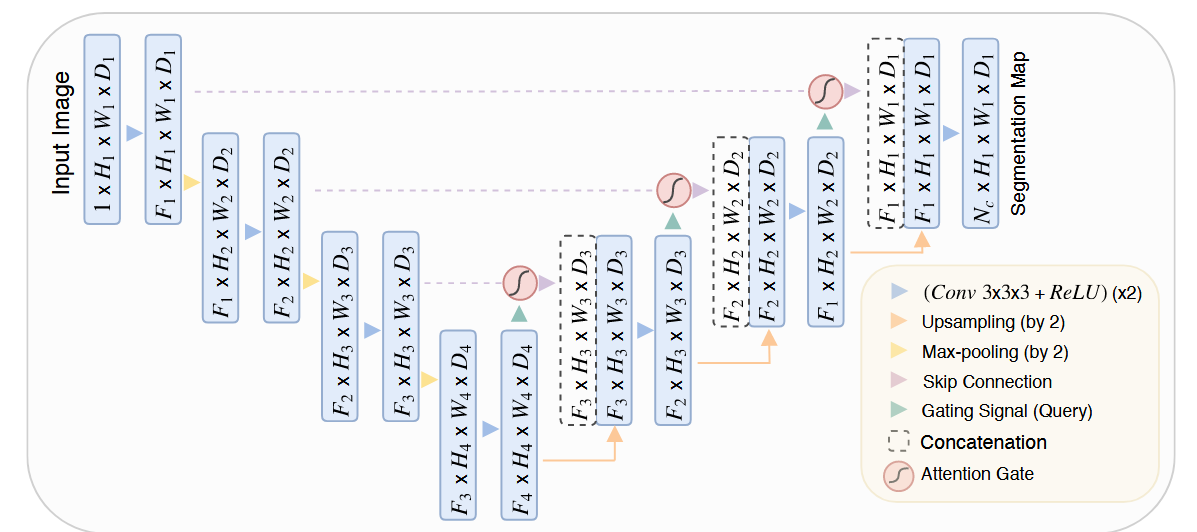

This added **Attention Module/Gate** has the **Following Architecture** $:$

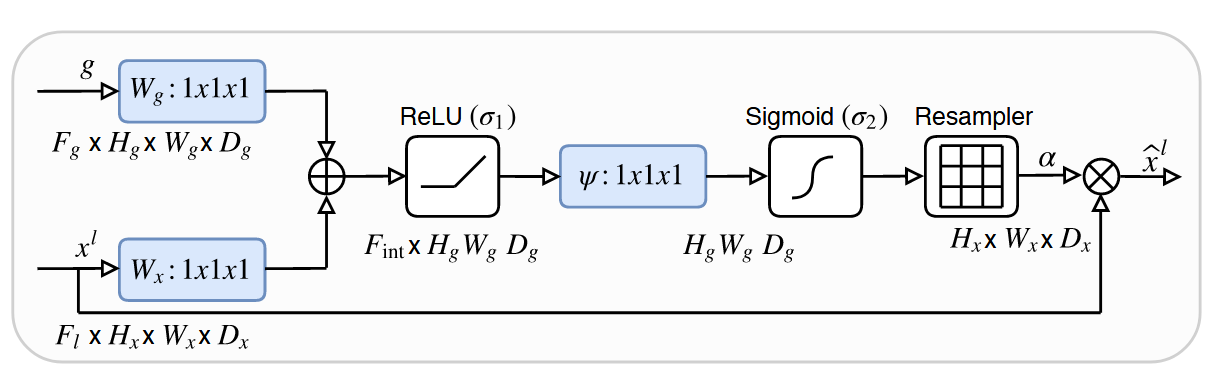

Where,
* $x$ are the **Skip Inputs**
* $g$ is the Input from **Previous Decoder**



This is a **Soft Attention Module** and it is self-explanatory for code look below :

---
$Bonus :$ [ViT](https://www.kaggle.com/code/utkarshsaxenadn/vit-vision-transformer-in-keras-tensorflow) is an example of a Hard Attention Model.

In [21]:
# Expansion
class DecoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate):
        super(DecoderBlock,self).__init__()
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.c1 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')

    def call(self, inputs):
        X, short_X = inputs
        ct = self.up(X)
        c_ = concatenate([ct, short_X])
        x = self.c1(c_)
        y = self.c2(x)
        return y

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate,
        }

In [22]:
class AttentionChannel(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(AttentionChannel, self).__init__(**kwargs)
        self.filters = filters
        
        self.C1 = Conv2D(filters, kernel_size=1, strides=1, padding='same', activation=None)
        self.C2 = Conv2D(filters, kernel_size=1, strides=2, padding='same', activation=None)
#         self.relu = keras.activations.ReLU()
        tf.keras.layers.Activation('relu')

        self.add = keras.layers.Add()
        self.C3 = Conv2D(1,kernel_size=1, strides=1, padding='same', activation='sigmoid')
        self.up = keras.layers.UpSampling2D()
        self.mul = keras.layers.Multiply()
        self.BN = BatchNormalization()
                
    def call(self, X):
        org_x, skip_g = X
        g = self.C1(org_x)
        x = self.C2(skip_g)
        x = self.add([g,x])
        x = self.C3(x)
        x = self.up(x)
        x = self.mul([x,skip_g])
        x = self.BN(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        base_config.update({
            "filters":self.filters
        })
        return base_config

In [23]:
#  Input
input_shape = (SIZE, SIZE, 3)
input_layer = Input(shape=input_shape)

# Encoder
p1, c1 = EncoderBlock(32,0.1)(input_layer)
p2, c2 = EncoderBlock(64,0.1)(p1)
p3, c3 = EncoderBlock(128,0.2)(p2)
p4, c4 = EncoderBlock(256,0.2)(p3)

# Latent Representation
c5 = EncoderBlock(512, 0.3, pooling=False)(p4)

# Attention-Decoder
a1 = AttentionChannel(256)([c5, c4])
d1 = DecoderBlock(256,0.2)([c5, a1])

a2 = AttentionChannel(128)([d1, c3])
d2 = DecoderBlock(128,0.2)([d1, a2])

a3 = AttentionChannel(64)([d2, c2])
d3 = DecoderBlock(64,0.1)([d2, a3])

a4 = AttentionChannel(32)([d3, c1])
d4 = DecoderBlock(32,0.1)([d3, a4])
# outputs
output_layer = Conv2D(1,kernel_size=1, strides=1, padding='same', activation='sigmoid')(d4)

Epoch 1/20
1/1 [==============================] - 0s 232ms/steps: 1.7550 - accuracy: 0.4512 - IoU: 0.35


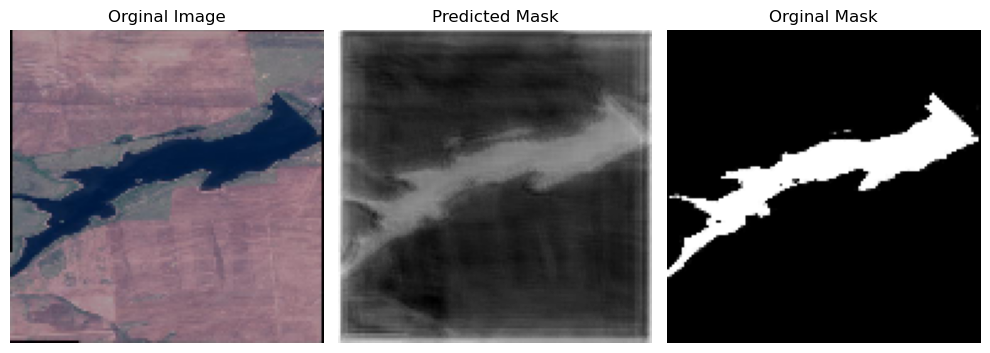

3/3 [==============================] - 20s 5s/step - loss: 1.7550 - accuracy: 0.4512 - IoU: 0.3568 - val_loss: 0.6286 - val_accuracy: 0.5286 - val_IoU: 0.3912
Epoch 2/20
1/1 [==============================] - 0s 39ms/stepss: 0.5664 - accuracy: 0.6100 - IoU: 0.35


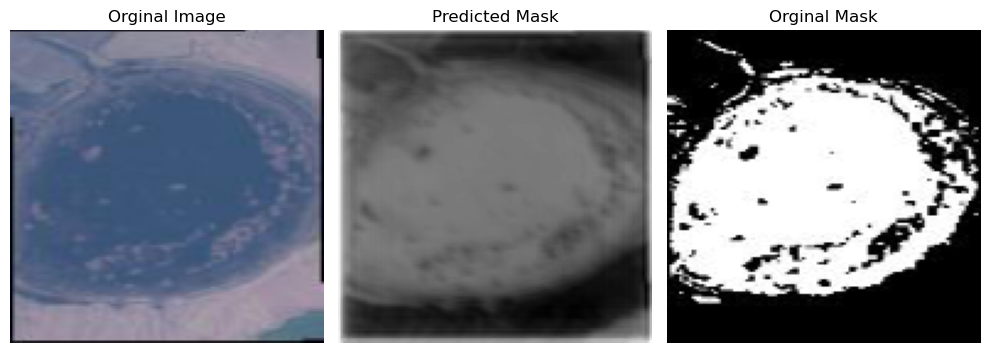

3/3 [==============================] - 16s 5s/step - loss: 0.5664 - accuracy: 0.6100 - IoU: 0.3568 - val_loss: 0.6221 - val_accuracy: 0.5282 - val_IoU: 0.3912
Epoch 3/20
1/1 [==============================] - 0s 38ms/stepss: 0.4886 - accuracy: 0.6483 - IoU: 0.35


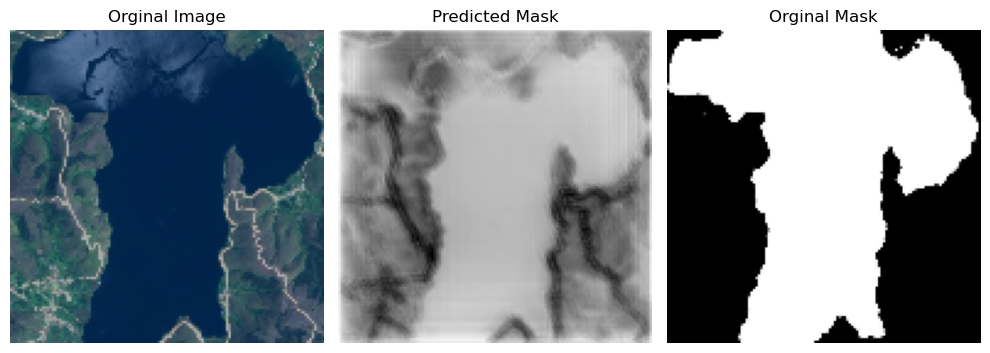

3/3 [==============================] - 15s 4s/step - loss: 0.4886 - accuracy: 0.6483 - IoU: 0.3568 - val_loss: 0.6292 - val_accuracy: 0.5281 - val_IoU: 0.3912
Epoch 4/20
1/1 [==============================] - 0s 37ms/stepss: 0.4689 - accuracy: 0.6528 - IoU: 0.35


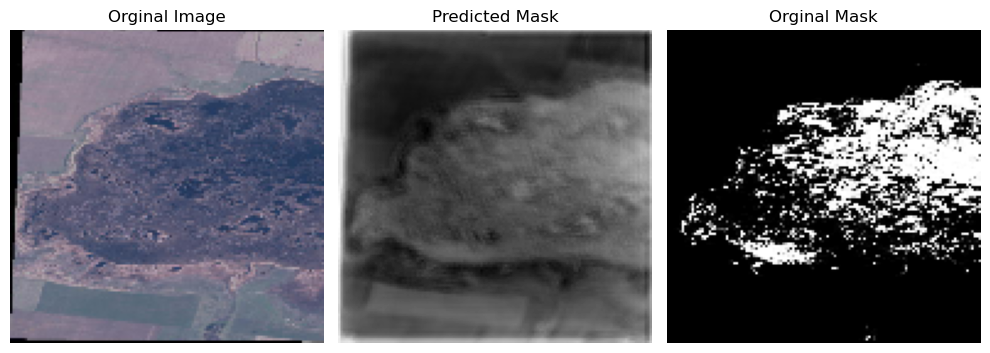

3/3 [==============================] - 14s 4s/step - loss: 0.4689 - accuracy: 0.6528 - IoU: 0.3568 - val_loss: 0.6281 - val_accuracy: 0.5281 - val_IoU: 0.3912
Epoch 5/20
1/1 [==============================] - 0s 39ms/stepss: 0.4455 - accuracy: 0.6711 - IoU: 0.35


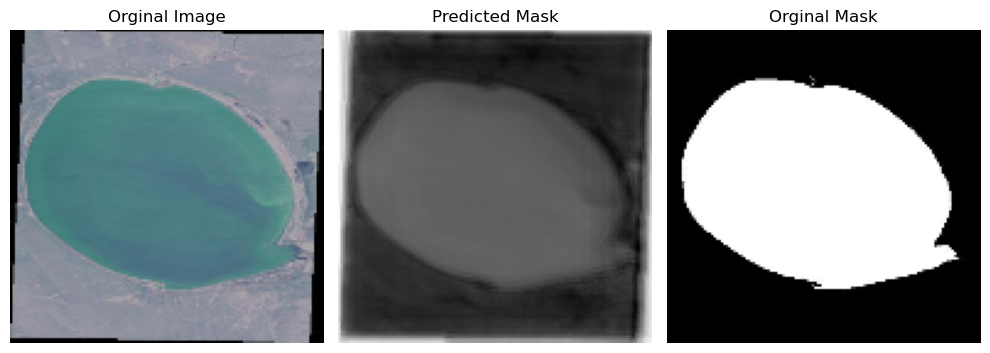

3/3 [==============================] - 15s 5s/step - loss: 0.4455 - accuracy: 0.6711 - IoU: 0.3568 - val_loss: 0.6412 - val_accuracy: 0.5277 - val_IoU: 0.3912


In [24]:
# Model
attention_unet = keras.models.Model(
    inputs=[input_layer],
    outputs=[output_layer],
)

# Compiling
attention_unet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2, name="IoU")]
)
# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),# The Model will train quickly use it if you want it, For model Comparision I am not using it
    ModelCheckpoint("AttentionUNet.h5", save_best_only=True),
    ShowProgress(SIZE=SIZE)
]

# Training
attention_history = attention_unet.fit(
    X,y,
    epochs=20,
    callbacks=callbacks,
    validation_split=0.1
)

Because the **Spatial Information** is shared through the **Skip Connections** and **Attention Model** Initialy pays attention to everything you can see that the Model was able to **keep the Spatial Information** till the **output layer**. This can be a good thing with works like **Lanscape Colorizer**. You can clearly Notice that the **Mask Predictions by Attention UNet are much clear.**

# **Model Comparision**

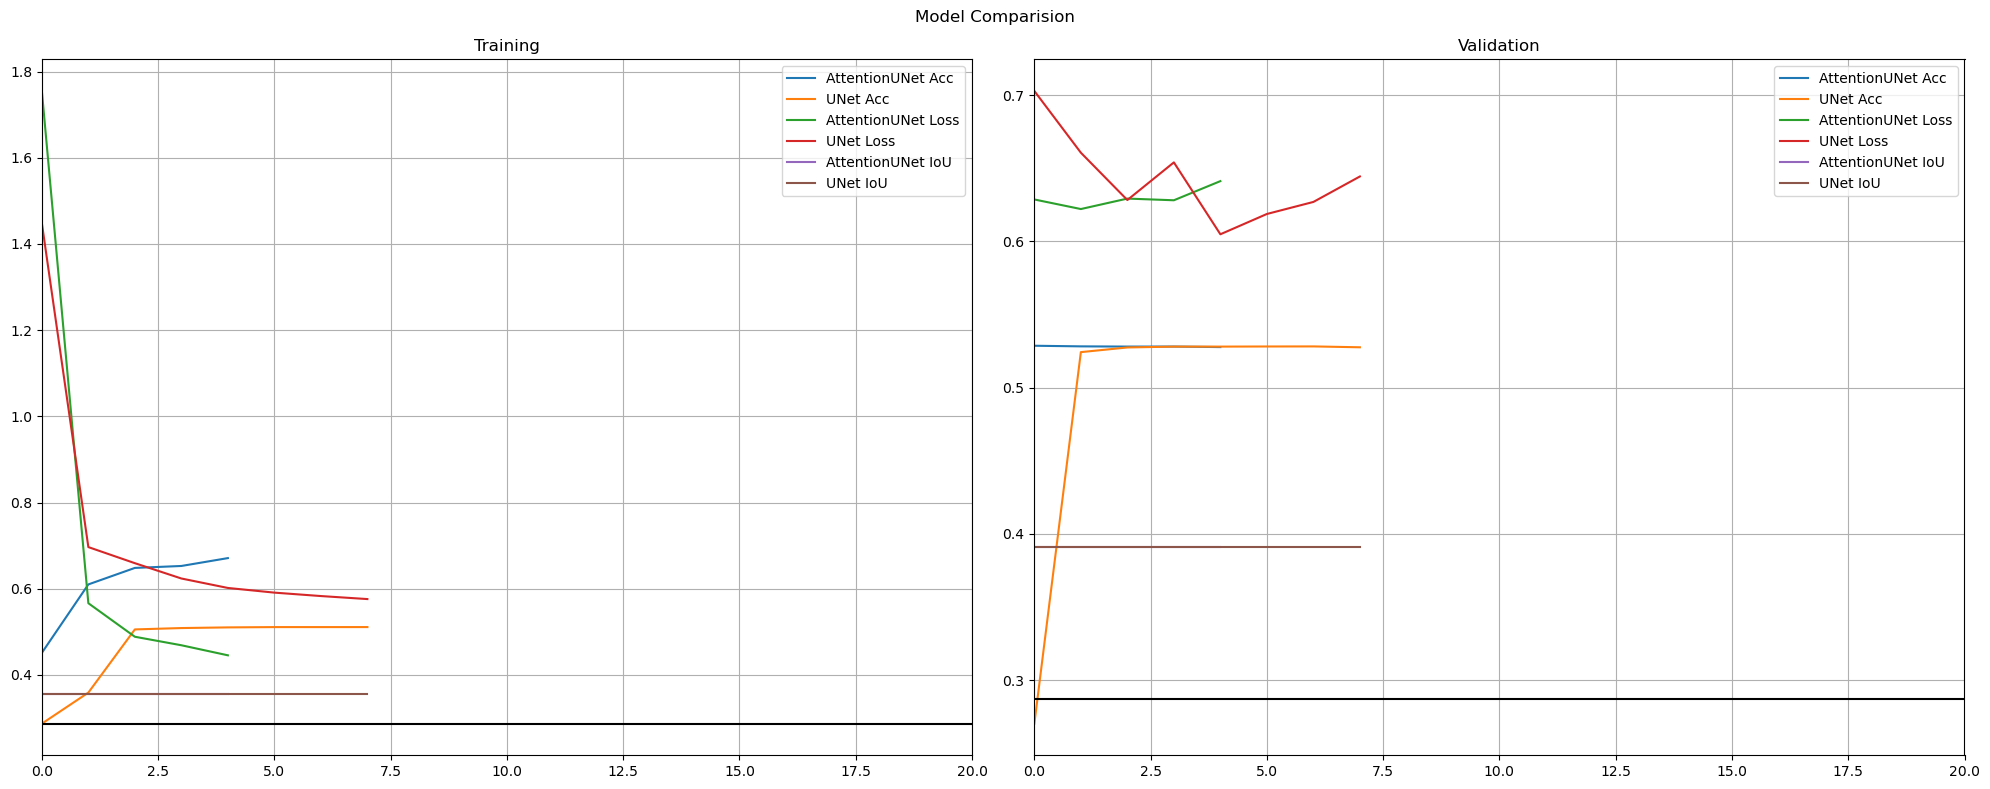

In [25]:
# learning Curves
attention_train_loss, attention_train_acc, attention_train_IoU, attention_valid_loss, attention_valid_acc, attention_valid_IoU  = attention_history.history.values()
unet_train_loss, unet_train_acc, unet_train_IoU, unet_valid_loss, unet_valid_acc, unet_valid_IoU = unet_history.history.values()

# Viz
plt.figure(figsize=(20,8))
plt.suptitle("Model Comparision")

plt.subplot(1,2,1)

plt.title("Training")
plt.plot(attention_train_acc, label="AttentionUNet Acc")
plt.plot(unet_train_acc, label="UNet Acc")

plt.plot(attention_train_loss, label="AttentionUNet Loss")
plt.plot(unet_train_loss, label="UNet Loss")

plt.plot(attention_train_IoU, label="AttentionUNet IoU")
plt.plot(unet_train_IoU, label="UNet IoU")
plt.axhline(min(attention_train_acc[0], unet_train_acc[0]), color='k')
plt.xlim([0,20])

plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation")
plt.plot(attention_valid_acc, label="AttentionUNet Acc")
plt.plot(unet_valid_acc, label="UNet Acc")

plt.plot(attention_valid_loss, label="AttentionUNet Loss")
plt.plot(unet_valid_loss, label="UNet Loss")

plt.plot(attention_valid_IoU, label="AttentionUNet IoU")
plt.plot(unet_valid_IoU, label="UNet IoU")
plt.axhline(min(attention_train_acc[0], unet_train_acc[0]), color='k')
plt.xlim([0,20])

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

We can clearly spot the difference, the loss is reduced that means the **Reconstruction has Improved** and in case of **Attention UNet** the **loss is lower** than the **Normal UNet**. Keep in mind that **UNet is best suited for Multi CLass Segmentationa and for Binary Class Segmentation SegNet works great.**

---
Let me know your suggestion, they help me to Improve.
**Thanks !!**